<a href="https://colab.research.google.com/github/Dominique9898/2048/blob/master/COMP5625M_assessment2024_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## COMP5625M Practical Assessment - Deep Learning [100 Marks]


<div class="logos"><img src="https://github.com/Dominique9898/dl-assessment/blob/main/Comp5625M_logo.jpg?raw=1" width="220px" align="right"></div>

This assessment is divided into two parts:
> 1. Image classification using DNN and CNN [70 Marks]
> 2. Use of RNN to predict texts for image captioning [30 Marks]

The maximum number of marks for each part is shown in the section headers. As indicated in the main heading above, the overall assessment carries a maximum of 100 marks.

This summative assessment is weighted 50% of the final grade for the module.


### Motivation

Through this coursework, you will:

> 1. Understand and implement your first deep neural network and convolutional neural network (CNN) and see how these can be used for classification problem
> 2. Practice building, evaluating, and finetuning your CNN on an image dataset from development to testing stage.
> 3. You will learn to tackle overfitting problem using strategies such as data augmentation and drop out.
> 4. Compare your model performance and accuracy with others, such as the leaderboard on Kaggle
> 5. Use RNNs to predict the caption of an image from established word vocabularies
> 6. Understand and visualise text predictions for a given image.


### Setup and resources

You must work using this provided template notebook.

Having a GPU will speed up the training process. See the provided document on Minerva about setting up a working environment for various ways to access a GPU.

Please implement the coursework using **Python and PyTorch**, and refer to the notebooks and exercises provided.


### Submission

Please submit the following:

> 1. Your completed Jupyter notebook file, without removing anything in the template, in **.ipynb format.**
> 2. The **.html version** of your notebook; File > Download as > HTML (.html). Check that all cells have been run and all outputs (including all graphs you would like to be marked) displayed in the .html for marking.
> 3. Your selected image from section 2.4.2 "Failure analysis"

Final note:

> **Please display everything that you would like to be marked. Under each section, put the relevant code containing your solution. You may re-use functions you defined previously, but any new code must be in the relevant section.** Feel free to add as many code cells as you need under each section.


Your student username (for example, ```sc15jb```):

ml22fw3

Your full name:

Fangling Wei

**Kaggle username:**

fanglingwei11

### Part I: Image Classification [70 marks]

#### Dataset
This coursework will use a subset of images from Tiny ImageNet, which is a subset of the [ImageNet dataset](https://www.image-net.org/update-mar-11-2021.php). Our subset of Tiny ImageNet contains **30 different categories**, we will refer to it as TinyImageNet30. The training set has 450 resized images (64x64 pixels) for each category (13,500 images in total). You can download the training and test set from the Kaggle website:

>[Direct access of data is possible by clicking here, please use your university email to access this](https://leeds365-my.sharepoint.com/:u:/g/personal/scssali_leeds_ac_uk/ESF87mN6kelIkjdISkaRow8BublW27jB-P8eWV6Rr4rxtw?e=SPASDB)

>[To submit your results on the Kaggle competition. You can also access data here](https://www.kaggle.com/t/9105198471a3490d9057026d27d8a711)

To access the dataset, you will need an account on the Kaggle website. Even if you have an existing Kaggle account, please carefully adhere to these instructions, or we may not be able to locate your entries:

> 1. Use your **university email** to register a new account.
> 2. Set your **Kaggle account NAME** to your university username, for example, ``sc15jb`` (see the ``note`` below)

``Note:`` If the name is already taken in the Kaggle then please use a similar pseudo name and add a note in your submission with the name you have used in the Kaggle.

#### Submitting your test result to Kaggle leaderboard
The class Kaggle competition also includes a blind test set, which will be used in Question 1 for evaluating your custom model's performance on a test set. The competition website will compute the test set accuracy, as well as position your model on the class leaderboard. More information is provided in the related section below.


## Required packages

[1] [numpy](http://www.numpy.org) is package for scientific computing with python

[2] [h5py](http://www.h5py.org) is package to interact with compactly stored dataset

[3] [matplotlib](http://matplotlib.org) can be used for plotting graphs in python

[4] [pytorch](https://pytorch.org/docs/stable/index.html) is library widely used for bulding deep-learning frameworks

Feel free to add to this section as needed some examples for importing some libraries is provided for you below.

You may need to install these packages using [pip](https://pypi.org/project/opencv-python/) or [conda](https://anaconda.org/conda-forge/opencv).

In [2]:
import cv2
import math
import os
import glob
import copy

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import pandas as pd

from torchvision import transforms, datasets
from torch.hub import load_state_dict_from_url
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, Dataset, DataLoader, random_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import torch.nn.functional as F

from PIL import Image
from itertools import cycle
from scipy import interp

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cpu')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# always check your version
print(torch.__version__)

2.1.0+cu121


One challenge of building a deep learning model is to choose an architecture that can learn the features in the dataset without being unnecessarily complex. The first part of the coursework involves building a CNN and training it on TinyImageNet30.

### **Overview of image classification:**

**1. Function implementation** [14 marks]

*   **1.1** PyTorch ```Dataset``` and ```DataLoader``` classes (4 marks)
*   **1.2** PyTorch ```Model``` class for a simple MLP model (4 marks)
*   **1.3** PyTorch ```Model``` class for a simple CNN model (6 marks)

**2. Model training** [30 marks]
*   **2.1** Training on TinyImageNet30 dataset (6 marks)
*   **2.2** Generating confusion matrices and ROC curves (6 marks)
*   **2.3** Strategies for tackling overfitting (18 marks)
    *   **2.3.1** Data augmentation
    *   **2.3.2** Dropout
    *   **2.3.3** Hyperparameter tuning (e.g. changing learning rate)
            
**3. Model testing** [10 marks]
*   **3.1**   Testing your final model in (2) on test set - code to do this (4 marks)
*   **3.2**   Uploading your result to Kaggle  (6 marks)

**4. Model Fine-tuning on CIFAR10 dataset** [16 marks]
*   **4.1** Fine-tuning your model (initialise your model with pretrained weights from (2)) (6 marks)
*   **4.2** Fine-tuning model with frozen base convolution layers (6 marks)
*   **4.3** Compare complete model retraining with pretrained weights and with frozen layers. Comment on what you observe. (4 marks)


<!-- **5. Model comparison** [16 marks]
*   **5.1**   Load pretrained AlexNet and finetune on TinyImageNet30 until model convergence (8 marks)
*   **5.2**   Compare the results of your model with pretrained AlexNet on the same validation set. Provide performance values (loss graph, confusion matrix, top-1 accuracy, execution time) (8 marks) -->
<!--
**6. Interpretation of results** (14 marks)
*   **6.1** Implement grad-CAM for your model and AlexNet (6 marks)
*   **6.2** Visualise and compare your results from your model and AlexNet (4 marks)
*   **6.3** Provide comment on (4 marks)
    - why the network predictions were correct or not correct in your predictions?
    - what can you do to improve your results further?

**7. Residual connection for deeper network** (9 marks)
*   **7.1** Implement a few residual layers in AlexNet and retrain on TinyImageNet30. You can change network size if you wish. (6 marks)
*   **7.2** Comment on why such connections are important and why this impacted your results in terms of loss and accuracy (if it did!) (3 marks)

**Quality of your report** (2 marks) -->


## 1 Function implementations [14 marks]


### 1.1 Dataset class (4 marks)

Write a PyTorch ```Dataset``` class (an example [here](https://www.askpython.com/python-modules/pytorch-custom-datasets) for reference) which loads the TinyImage30 dataset and ```DataLoaders``` for training and validation sets.

In [1]:
# init lables and create an instance of dataset
base_dir = "/content/drive/MyDrive/comp5625m-artificial-intelligence-2024"
class_to_idx = {}
with open(base_dir + '/class.txt', 'r') as f:
    for line in f:
        class_idx, class_name = line.strip().split()
        class_to_idx[class_name] = int(class_idx)

print(class_to_idx)
print(len(class_to_idx.keys()))

{'baboon': 0, 'banana': 1, 'bee': 2, 'bison': 3, 'butterfly': 4, 'candle': 5, 'cardigan': 6, 'chihuahua': 7, 'elephant': 8, 'espresso': 9, 'fly': 10, 'goldfish': 11, 'goose': 12, 'grasshopper': 13, 'hourglass': 14, 'icecream': 15, 'ipod': 16, 'jellyfish': 17, 'koala': 18, 'ladybug': 19, 'lion': 20, 'mushroom': 21, 'penguin': 22, 'pig': 23, 'pizza': 24, 'pretzel': 25, 'redpanda': 26, 'refrigerator': 27, 'sombrero': 28, 'umbrella': 29}
30


In [11]:
class TinyImage30Dataset:
    def __init__(self, base_dir, class_to_idx, transform=None, batch_size = 32, num_workers = 0):

        self.base_dir = base_dir
        self.transform = transform
        self.num_workers = num_workers
        self.batch_size = batch_size
        self.num_workers = num_workers
        if self.transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((64, 64)),
                transforms.RandomCrop(64, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.2749, 0.3338, 0.3453],
                                    std=[0.2120, 0.2220, 0.2379])
            ])
        self.class_to_idx = class_to_idx
        self.images = []

        # Load the datasets
        self.full_train_dataset = datasets.ImageFolder(os.path.join(self.base_dir, 'train_set'), transform=self.transform)
        self.train_dataset = self.full_train_dataset
        self.valid_dataset = None

        for class_name, class_idx in class_to_idx.items():
            class_dir = os.path.join(os.path.join(self.base_dir, 'train_set'), class_name)
            # Loop through all the images in class folder
            for img_name in os.listdir(class_dir):
                self.images.append((os.path.join(class_dir, img_name), class_idx))

    def split_train_valid(self, test_ratio):
        n_total = len(self.full_train_dataset)
        n_test = int(n_total * test_ratio)
        n_train = n_total - n_test
        self.train_dataset, self.valid_dataset = random_split(self.full_train_dataset, [n_train, n_test])

    def get_train_loader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def get_valid_loader(self):
        return DataLoader(self.valid_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, class_idx = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, class_idx


In [12]:
# TEST

dataset = TinyImage30Dataset(base_dir=base_dir, class_to_idx=class_to_idx)
print(len(dataset.train_dataset))
dataset.split_train_valid(0.5)
for X, y in dataset.get_valid_loader():
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

13530
Shape of X [N, C, H, W]:  torch.Size([32, 3, 64, 64])
Shape of y:  torch.Size([32]) torch.int64


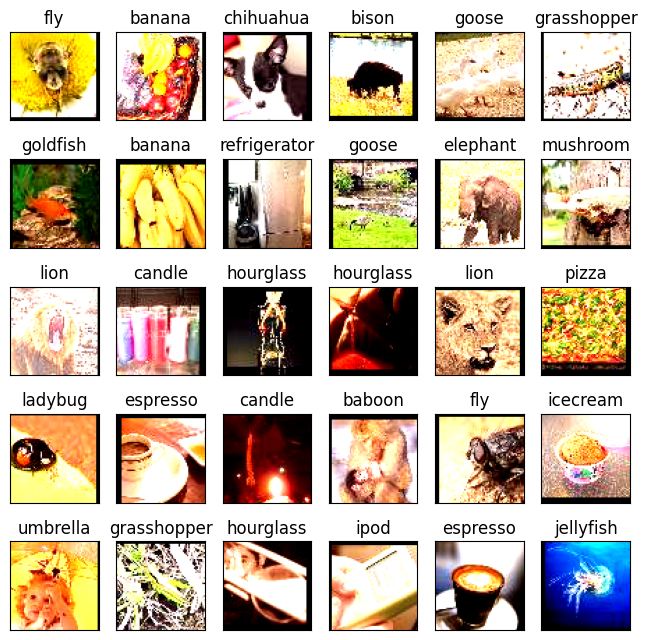

In [13]:
# draw some training pictures
real_batch = next(iter(dataset.get_valid_loader()))
def denormalize(image):
    image = image * 0.5 + 0.5
    image = image.clamp(0, 1)
    image = image.numpy()
    return np.transpose(image, (1, 2, 0))

def show_images(batch, num_images=30):
    images, labels = batch
    fig = plt.figure(figsize=(8, 8))
    for i in range(num_images):
        ax = fig.add_subplot(5, 6, i + 1, xticks=[], yticks=[])
        ax.imshow(denormalize(images[i]))

        idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
        ax.set_title(idx_to_class[labels[i].item()])

# Visualize the batch
show_images(real_batch)

### 1.2 Define a MLP model class (4 marks)

<u>Create a new model class using a combination of:</u>
- Input Units
- Hidden Units
- Output Units
- Activation functions
- Loss function
- Optimiser

In [ ]:
class MLPModel(nn.Module):
    def __init__(self, input_units, hidden_units, output_units):
        super(MLPModel, self).__init__()

        self.input_layer = nn.Linear(input_units, hidden_units[0])

        self.hidden_layers = nn.ModuleList()
        for i in range(1, len(hidden_units)):
            self.hidden_layers.append(nn.Linear(hidden_units[i-1], hidden_units[i]))

        self.output_layer = nn.Linear(hidden_units[-1], output_units)

        self.activation = nn.ReLU()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.activation(self.input_layer(x))

        for hidden_layer in self.hidden_layers:
            x = self.activation(hidden_layer(x))

        x = self.output_layer(x)
        return x

    def get_loss_function(self):
        return nn.CrossEntropyLoss()

    def get_optimizer(self, lr):
        return optim.Adam(self.parameters(), lr=lr)


### 1.3 Define a CNN model class (6 marks)

<u>Create a new model class using a combination of:</u>
- Convolution layers
- Activation functions (e.g. ReLU)
- Maxpooling layers
- Fully connected layers
- Loss function
- Optimiser

*Please note that the network should be at least a few layers for the model to perform well.*

In [20]:
# define a CNN Model class
class CNNModel(nn.Module):
    def __init__(self, num_classes=30, dropout = 0.5):
        super(CNNModel, self).__init__()
        self.num_classes = num_classes
        self.layer1 = self.conv_module(3, 16)
        self.layer2 = self.conv_module(16, 32)
        self.layer3 = self.conv_module(32, 64)
        self.layer4 = self.conv_module(64, 128)
        self.layer5 = self.conv_module(128, 256)
        self.gap = self.global_avg_pool(256, self.num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.gap(out)
        out = out.view(-1, self.num_classes)

        return out

    def conv_module(self, in_num, out_num):
        return nn.Sequential(
            nn.Conv2d(in_num, out_num, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_num),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

    def global_avg_pool(self, in_num, out_num):
        return nn.Sequential(
            nn.Conv2d(in_num, out_num, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_num),
            nn.LeakyReLU(),
            nn.AdaptiveAvgPool2d((1, 1)))


    def get_loss_function(self):
        return nn.CrossEntropyLoss()

    def get_optimizer(self, lr):
        return torch.optim.Adam(self.parameters(), lr=lr)

## 2 Model training [30 marks]


### 2.1 Train both MLP and CNN model - show loss and accuracy graphs side by side (6 marks)

Train your model on the TinyImageNet30 dataset. Split the data into train and validation sets to determine when to stop training. Use seed at 0 for reproducibility and test_ratio=0.2 (validation data)

Display the graph of training and validation loss over epochs and accuracy over epochs to show how you determined the optimal number of training epochs. A top-*k* accuracy implementation is provided for you below.

> Please leave the graph clearly displayed. Please use the same graph to plot graphs for both train and validation.


In [15]:
# (HelperDL function) -- Define top-*k* accuracy (**new**)
def topk_accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [23]:
from tqdm import tqdm

class Trainer:
    def __init__(self, dataset, model, num_epochs=10, save_model=False, model_file_name="best_model"):
      self.num_epochs = num_epochs
      self.model = model
      self.dataset = dataset
      self.save_model = save_model
      self.model_file_name = model_file_name
      self.train_loader = self.dataset.get_train_loader()
      self.valid_loader = self.dataset.get_valid_loader()

      self.train_losses, self.valid_losses = [], []
      self.train_accuracies, self.valid_accuracies = [], []

    def train(self, lr=0.001):
        best_val_loss = float('inf')
        best_model_wts = copy.deepcopy(self.model.state_dict())

        # Early Stopping
        epochs_without_improvement = 0
        waiting_stop = 3

        # Loss and optimizer
        self.criterion = self.model.get_loss_function()
        self.optimizer = self.model.get_optimizer(lr)
        self.scheduler = lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min', patience=5, factor=0.5)


        for epoch in range(self.num_epochs):
            # Training
            self.model.train()
            train_loss = 0.0
            train_corrects = 0

            train_loader = tqdm(self.train_loader, desc=f'Epoch {epoch+1}/{self.num_epochs}, Training', leave=False, position=0)

            for inputs, labels in self.train_loader:

                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                self.optimizer.zero_grad()

                loss.backward()
                self.optimizer.step()

                train_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                train_corrects += torch.sum(preds == labels.data)

                train_loader.set_postfix(train_loss=train_loss)

            train_loss = train_loss / len(self.train_loader.dataset)
            train_acc = train_corrects.double() / len(self.train_loader.dataset)

            self.train_losses.append(train_loss)
            self.train_accuracies.append(train_acc.item())

            # Validation
            self.model.eval()
            valid_loss = 0.0
            valid_corrects = 0
            topk_accs = []

            valid_loader = tqdm(self.valid_loader, desc=f'Epoch {epoch+1}/{self.num_epochs}, Validation', leave=False, position=0)

            with torch.no_grad():
                for inputs, labels in self.valid_loader:
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, labels)
                    valid_loss += loss.item() * inputs.size(0)
                    # Top-k accuracy calculation
                    accs = topk_accuracy(outputs, labels, topk=(1,))
                    topk_accs.append(accs[0].item())
                    _, preds = torch.max(outputs, 1)
                    valid_corrects += torch.sum(preds == labels.data)

                    valid_loader.set_postfix(valid_loss=valid_loss)

            valid_loss /= len(self.valid_loader.dataset)
            valid_acc = valid_corrects.double() / len(self.valid_loader.dataset)
            self.valid_losses.append(valid_loss)
            self.valid_accuracies.append(valid_acc.item())

            # Early stopping check
            if valid_loss < best_val_loss:
                best_val_loss = valid_loss
                best_model_wts = copy.deepcopy(self.model.state_dict())
                if self.save_model:
                    torch.save(self.model.state_dict(), f'{self.model_file_name}.pth')
                print(f"New best model saved at epoch {epoch+1} with Val Loss: {valid_loss:.4f}")
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
                if epochs_without_improvement >= waiting_stop:
                    print(f'Validation loss did not improve for {waiting_stop} epochs. Early stopping...')
                    break

            self.scheduler.step(valid_loss)

            print(f'Epoch {epoch+1}/{self.num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
                  f'Val Loss: {valid_loss:.4f}, Val Acc: {valid_acc:.4f}, Top-1 Val Acc: {sum(topk_accs)/len(topk_accs):.4f}')

            # Load the best model weights before returning
            self.model.load_state_dict(best_model_wts)

    def draw_metrics(self):
      epochs = range(1, len(self.train_losses) + 1)
      plt.figure(figsize=(12, 5))

      plt.subplot(1, 2, 1)
      plt.plot(epochs, self.train_losses, 'bo-', label='Training Loss')
      plt.plot(epochs, self.valid_losses, 'ro-', label='Validation Loss')
      plt.title('Training and Validation Loss')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.legend()

      plt.subplot(1, 2, 2)
      plt.plot(epochs, self.train_accuracies, 'bo-', label='Training Accuracy')
      plt.plot(epochs, self.valid_accuracies, 'ro-', label='Validation Accuracy')
      plt.title('Training and Validation Accuracy')
      plt.xlabel('Epochs')
      plt.ylabel('Accuracy')
      plt.legend()

      plt.tight_layout()
      plt.show()

In [18]:
# Set the seed for reproducibility
torch.manual_seed(0)

In [ ]:
# MLP Model
# params: input_units 64x64 RGB images, hidden_units, output_units Number of classes
mlp_model = MLPModel(64 * 64 * 3, [1024, 512], len(class_to_idx))

mlp_dataset = TinyImage30Dataset(base_dir=base_dir, class_to_idx=class_to_idx)
mlp_dataset.split_train_valid(test_ratio=0.2)

mlp_trainer = Trainer(mlp_dataset, model = mlp_model,  model_file_name='best_mlp_model')

In [ ]:
mlp_trainer.train()
mlp_trainer.draw_metrics()

In [24]:
#TO COMPLETE --> Running your CNN model class

cnn_dataset = TinyImage30Dataset(base_dir=base_dir, class_to_idx=class_to_idx, batch_size=32)
cnn_dataset.split_train_valid(test_ratio=0.2)

cnn_model = CNNModel(len(class_to_idx)).to(device)
cnn_model

CNNModel(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(64,

In [ ]:
cnn_trainer = Trainer(cnn_dataset, cnn_model, save_model=True, model_file_name='best_cnn_model')
cnn_trainer.train()

Epoch 1/10, Training:   0%|          | 0/339 [00:41<?, ?it/s, train_loss=9.59e+3]

> **TODO:**Comment on your model and the results you have obtained. This should include the number of parameters for each of your models and briefly explain why one should use CNN over MLP for the image classification problem.

### 2.2 Generating confusion matrix and ROC curves (6 marks)
- Use your CNN architecture with best accuracy to generate two confusion matrices, one for the training set and another for the validation set. Remember to use the whole validation and training sets, and to include all your relevant code. Display the confusion matrices in a meaningful way which clearly indicates what percentage of the data is represented in each position.
- Display an ROC curve for the two top and two bottom classes with area under the curve

In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_names, title):
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=class_names, yticklabels=class_names,
           title='Confusion matrix (normalized)',
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.title(title)
    plt.show()

# Function to plot ROC curve
def plot_roc_curve(fpr, tpr, roc_auc, num_classes, title):
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple', 'cyan'])
    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multiclass')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
# Function to calculate confusion matrix and ROC
def evaluate_model(model, data_loader, num_classes):
    model.eval()
    all_labels = []
    all_preds = []
    all_outputs = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            all_outputs.extend(outputs.cpu().numpy())

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print('Accuracy:', accuracy)

    y_true = label_binarize(all_labels, classes=range(num_classes))
    y_scores = np.array(all_outputs)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    cm = confusion_matrix(all_labels, all_preds, normalize='true')

    return cm, fpr, tpr, roc_auc

In [ ]:
cnn_model.load_state_dict(torch.load('best_cnn_model.pth'))
cnn_model.eval()
train_loader = cnn_dataset.get_train_loader()
valid_loader = cnn_dataset.get_valid_loader()


In [ ]:
# Evaluate on training set
train_cm, train_fpr, train_tpr, train_roc_auc = evaluate_model(cnn_model, train_loader, num_classes=len(class_to_idx))
plot_confusion_matrix(train_cm, class_names=class_to_idx.keys(), title = "Confusion Matrix of Training Set")
plot_roc_curve(train_fpr, train_tpr, train_roc_auc, num_classes, title = "Roc Curve of Training Set")


# Evaluate on validation set
valid_cm, valid_fpr, valid_tpr, valid_roc_auc = evaluate_model(cnn_model, valid_loader, device, num_classes=len(class_to_idx))
plot_confusion_matrix(valid_cm, class_names=class_to_idx.keys(), title = "Confusion Matrix of Validation set")
plot_roc_curve(valid_fpr, valid_tpr, valid_roc_auc, num_classes,title = "Roc Curve of Validation Set")


# Plot ROC curves for the top 2 and bottom 2 classes by AUC
# For simplicity, let's assume class 0 and 1 are top, and class 2 and 3 are bottom
# plot_roc_curve({i: train_fpr[i] for i in [0, 1, 2, 3]},
#                {i: train_tpr[i] for i in [0, 1, 2, 3]},
#                {i: train_roc_auc[i] for i in [0, 1, 2, 3]},
#                num_classes=4)

### Redesign your CNN model (optional)
> This is optional and does not carry any marks. Often to tackle model underfitting we tend to make more complex network design. Depending on your observation, you can improve your model if you wish.

**Note: All questions below here relates to the CNN model only and not an MLP model! You are advised to use your final CNN model only for each of the questions below.**

### 2.3 Strategies for tackling overfitting (18 marks)
Using your (final) CNN model perform the strategies below to avoid overfitting problems. You can resuse the network weights from previous training, often referred to as ``fine tuning``.
*   **2.3.1** Data augmentation
*   **2.3.2** Dropout
*   **2.3.3** Hyperparameter tuning (e.g. changing learning rate)

> Plot loss and accuracy graphs per epoch side by side for each implemented strategy.

#### 2.3.1 Data augmentation (6 marks)

> Implement at least five different data augmentation techniques that should include both photometric and geometric augmentations.

> Provide graphs and comment on what you observe.


New best model saved at epoch 1 with Val Loss: 1.7879
Epoch 1/10 - Train Loss: 1.8623, Train Acc: 0.4749, Val Loss: 1.7879, Val Acc: 0.4926, Top-1 Val Acc: 49.2647
Epoch 2/10 - Train Loss: 1.7367, Train Acc: 0.5064, Val Loss: 1.9335, Val Acc: 0.4568, Top-1 Val Acc: 45.6127
Epoch 3/10 - Train Loss: 1.7558, Train Acc: 0.5018, Val Loss: 1.8253, Val Acc: 0.4956, Top-1 Val Acc: 49.5016
New best model saved at epoch 4 with Val Loss: 1.7862
Epoch 4/10 - Train Loss: 1.7469, Train Acc: 0.5058, Val Loss: 1.7862, Val Acc: 0.4963, Top-1 Val Acc: 49.5752
Epoch 5/10 - Train Loss: 1.6762, Train Acc: 0.5230, Val Loss: 1.8354, Val Acc: 0.4904, Top-1 Val Acc: 49.0441
Epoch 6/10 - Train Loss: 1.6703, Train Acc: 0.5226, Val Loss: 1.8864, Val Acc: 0.4793, Top-1 Val Acc: 47.8554
Epoch 7/10 - Train Loss: 1.6853, Train Acc: 0.5208, Val Loss: 1.8001, Val Acc: 0.4900, Top-1 Val Acc: 49.0074
Epoch 8/10 - Train Loss: 1.6656, Train Acc: 0.5276, Val Loss: 1.8136, Val Acc: 0.4989, Top-1 Val Acc: 49.9183
Epoch 9/10 -

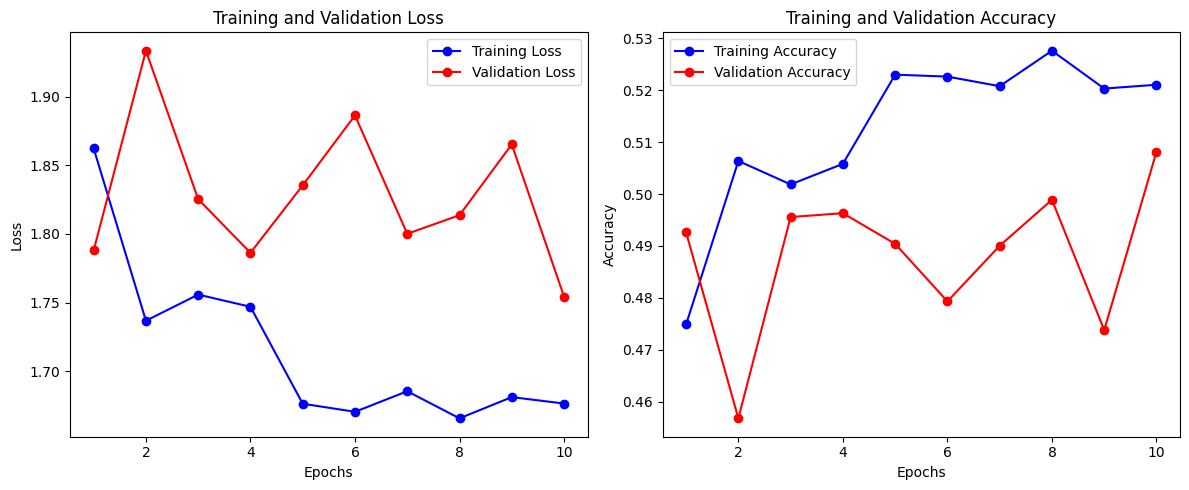

In [ ]:
# Your code here!
augmentation_transforms = transforms.Compose([
    transforms.Resize((64, 64)),              # Resize images to 64x64
    transforms.RandomHorizontalFlip(),        # Horizontal flip
    transforms.RandomRotation(10),            # Rotate by 10 degrees
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),  # Random crop and resize back to 64x64
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Color jitter
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random translation
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5)),
    transforms.ToTensor(),                    # Convert images to PyTorch tensors
])
dataset_with_aug = TinyImage30Dataset(base_dir=base_dir, class_to_idx=class_to_idx, transform = augmentation_transforms)
dataset_with_aug.split_train_valid(test_ratio=0.2)
cnn_model_with_aug = CNNModel()

cnn_with_aug_trainer = Trainer(dataset_with_aug, cnn_model_with_aug, save_model=True, model_file_name='best_cnn_model_with_aug')
cnn_with_aug_trainer.train(0.001)
cnn_with_aug_trainer.draw_metrics()

#### 2.3.2 Dropout (6 marks)

> Implement dropout in your model

> Provide graphs and comment on your choice of proportion used.

In [ ]:
# Your code here!
dropout_rates = [0.0, 0.1, 0.25]  # 0.5 has already be set
for rate in dropout_rates:
    model = CNNModel(num_classes=len(class_to_idx), dropout_rate = rate)
    model_with_dropout_trainer = Trainer(cnn_dataset, model, class_to_idx, save_model=True, model_file_name=f'best_cnn_model_dropout_{rate}')
    model_with_dropout_trainer.train()
    print(f"==============Dropout Rate {rate}==============")
    model_with_dropout_trainer.draw_metrics()

#### 2.3.3 Hyperparameter tuning (6 marks)

> Use learning rates [0.1, 0.001, 0.0001].

> Provide graphs each for loss and accuracy at three different learning rates in a single graph.

In [ ]:
# Your code here!
learning_rates = [0.1, 0.001, 0.0001]
for rate in learning_rates:
  cnn_with_lr_trainer = Trainer(cnn_dataset, cnn_model, class_to_idx=class_to_idx,save_model=True, model_file_name=f'best_cnn_model_lr_{rate}')
  cnn_with_lr_trainer.train(rate)
  print(f"==============Learning Rate {rate}==============")
  cnn_with_lr_trainer.draw_metrics()

### 3 Model testing [10 marks]
Online evaluation of your model performance on the test set.

> Prepare the dataloader for the testset.

> Write evaluation code for writing predictions.

> Upload it to Kaggle submission page (6 marks)


#### 3.1 Test class and predictions (4 marks)

> Build a test class, prepare a test dataloader and generate predictions

Create a PyTorch ```Dataset``` for the unlabeled test data in the test_set folder of the Kaggle competition and generate predictions using your final model. Test data can be downloaded [here](https://www.kaggle.com/competitions/comp5623m-artificial-intelligence/data?select=test_set).

In [ ]:
# Your code here!
from natsort import natsorted
class TinyImage30TestDataset(Dataset):
    def __init__(self, base_dir, transform=None):
        self.base_dir = os.path.join(base_dir, 'test_set')
        self.transform = transform
        self.all_imgs = os.listdir(self.base_dir)
        self.n_imgs = natsorted(self.all_imgs)

    def __len__(self):
        return len(self.n_imgs)

    def __getitem__(self, idx):
        img_name = self.n_imgs[idx]
        img_loc = os.path.join(self.base_dir, img_name)

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        return image, img_name

#### 3.2 Prepare your submission and upload to Kaggle  (6 marks)

Save all test predictions to a CSV file and submit it to the private class Kaggle competition. **Please save your test CSV file submissions using your student username (the one with letters, e.g., ``sc15jb``, not the ID with only numbers)**, for example, `sc15jb.csv`. That will help us to identify your submissions.

The CSV file must contain only two columns: ‘Id’ and ‘Category’ (predicted class ID) as shown below:

```txt
Id,Category
28d0f5e9_373c.JPEG,2
bbe4895f_40bf.JPEG,18
```

The ‘Id’ column should include the name of the image. It is important to keep the same name as the one on the test set. Do not include any path, just the name of file (with extension). Your csv file must contain 1501 rows, one for each image on test set and 1 row for the headers. [To submit please click here.](https://www.kaggle.com/t/917fe52f6a3c4855880a24b34f26db07)

> You may submit multiple times. We will use your personal top entry for allocating marks for this [6 marks].


In [ ]:
# Your code here!
test_transform = transforms.Compose([
                transforms.Resize((256, 256)),
                transforms.RandomCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.2749, 0.3338, 0.3453],
                                    std=[0.2120, 0.2220, 0.2379])])

test_dataset = TinyImage30TestDataset(base_dir=base_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
cnn_model.eval()
cnn_model.load_state_dict(torch.load('best_cnn_model.pth'))

predictions = []
with torch.no_grad():
    for images, img_names in test_loader:
        images = images.to(device)
        outputs = cnn_model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(zip(img_names, predicted.cpu().numpy()))

submission_df = pd.DataFrame(predictions, columns=['Id', 'Category'])

student_username = 'ml22fw3'
submission_df.to_csv(f'{student_username}.csv', index=False)

RuntimeError: Error(s) in loading state_dict for CNNModel:
	Missing key(s) in state_dict: "layer1.0.weight", "layer1.0.bias", "layer1.1.weight", "layer1.1.bias", "layer1.1.running_mean", "layer1.1.running_var", "layer2.0.weight", "layer2.0.bias", "layer2.1.weight", "layer2.1.bias", "layer2.1.running_mean", "layer2.1.running_var", "layer3.0.weight", "layer3.0.bias", "layer3.1.weight", "layer3.1.bias", "layer3.1.running_mean", "layer3.1.running_var", "layer4.0.weight", "layer4.0.bias", "layer4.1.weight", "layer4.1.bias", "layer4.1.running_mean", "layer4.1.running_var", "layer5.0.weight", "layer5.0.bias", "layer5.1.weight", "layer5.1.bias", "layer5.1.running_mean", "layer5.1.running_var", "gap.0.weight", "gap.0.bias", "gap.1.weight", "gap.1.bias", "gap.1.running_mean", "gap.1.running_var". 
	Unexpected key(s) in state_dict: "conv1.weight", "conv1.bias", "conv2.weight", "conv2.bias", "fc1.weight", "fc1.bias", "fc2.weight", "fc2.bias". 


### 4 Model Fine-tuning/transfer learning on CIFAR10 dataset  [16 marks]

Fine-tuning is a way of applying or utilizing transfer learning. It is a process that takes a model that has already been trained for one given task and then tunes or tweaks the model to make it perform a second similar task. You can perform fine-tuning in following fashion:

- Train an entire model: Start training model from scratch (large dataset, more computation)

- Train some layers, freeze others: Lower layer features are general (problem independent) while higher layer features are specific (problem dependent – freeze)

- Freeze convolution base and train only last FC layers (small dataset and lower computation)

> **Configuring your dataset**
   - Download your dataset using ``torchvision.datasets.CIFAR10`` [explained here](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html)
   - Split training dataset into training and validation set similar to above. *Note that the number of categories here is only 10*


In [ ]:
# Your code here!
train_ds = torchvision.datasets.CIFAR10('data',
                                      train=True,
                                      transform=torchvision.transforms.ToTensor(),
                                      download=True)

test_ds  = torchvision.datasets.CIFAR10('data',
                                      train=False,
                                      transform=torchvision.transforms.ToTensor(),
                                      download=True)

> Load pretrained AlexNet from PyTorch - use model copies to apply transfer learning in different configurations

In [ ]:
# Your code here!

#### 4.1 Apply transfer learning with pretrained model weights (6 marks)


> Configuration 1: No frozen layers

In [ ]:
# Your model changes here - also print trainable parameters

#### 4.2 Fine-tuning model with frozen layers (6 marks)

> Configuration 2: Frozen base convolution blocks

In [ ]:
# Your changes here - also print trainable parameters

#### 4.3 Compare above configurations and comment on performances. (4 marks)

In [ ]:
# Your graphs here and please provide comment in markdown in another cell

### Part II: Image Captioning using RNN [30 marks]



### Motivation

Through this part of assessment you will:

> 1. Understand the principles of text pre-processing and vocabulary building (provided).
> 2. Gain experience working with an image to text model.
> 3. Use and compare text similarity metrics for evaluating an image to text model, and understand evaluation challenges.

#### Dataset
This assessment will use a subset of the [COCO "Common Objects in Context" dataset](https://cocodataset.org/) for image caption generation. COCO contains 330K images, of 80 object categories, and at least five textual reference captions per image. Our subset consists of nearly 5070 of these images, each of which has five or more different descriptions of the salient entities and activities, and we will refer to it as COCO_5070.

To download the data:

> 1. **Images and annotations**: download the zipped file provided in the link here as [``COMP5625M_data_assessment_2.zip``](https://leeds365-my.sharepoint.com/:u:/g/personal/scssali_leeds_ac_uk/EWWzE-_AIrlOkvOKxH4rjIgBF_eUx8KDJMPKM2eHwCE0dg?e=DdX62H).

``Info only:`` To understand more about the COCO dataset you can look at the [download page](https://cocodataset.org/#download). We have already provided you with the "2017 Train/Val annotations (241MB)" but our image subset consists of fewer images compared to orginial COCO dataset. So, no need to download anything from here!

> 2. **Image meta data**: as our set is a subset of full COCO dataset, we have created a CSV file containing relevant meta data for our particular subset of images. You can download it also from Drive, "coco_subset_meta.csv" at the same link as 1.

#### Submission

You can either submit the same file or make a two separate .ipython notebook files zipped in the submission (please name as ``yourstudentusername_partI.ipynb`` and ``yourstudentusername_partII.ipynb``).

**Final note:**

> **Please include in this notebook everything that you would like to be marked, including figures. Under each section, put the relevant code containing your solution. You may re-use functions you defined previously, but any new code must be in the relevant section.** Feel free to add as many code cells as you need under each section.


The basic principle of our image-to-text model is as pictured in the diagram below, where an Encoder network encodes the input image as a feature vector by providing the outputs of the last fully-connected layer of a pre-trained CNN (we use [ResNet50](https://arxiv.org/abs/1512.03385)). This pretrained network has been trained on the complete ImageNet dataset and is thus able to recognise common objects.

You can alternatively use the COCO trained pretrained weights from [PyTorch](https://pytorch.org/vision/stable/models.html). One way to do this is use the "FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1" but use e.g., "resnet_model = model.backbone.body". Alternatively, you can use the checkpoint from your previous coursework where you fine-tuned to COCO dataset.

These features are then fed into a Decoder network along with the reference captions. As the image feature dimensions are large and sparse, the Decoder network includes a linear layer which downsizes them, followed by *a batch normalisation layer to speed up training*. Those resulting features, as well as the reference text captions, are then passed into a recurrent network (we will use an **RNNs** in this assessment).

The reference captions used to compute loss are represented as numerical vectors via an **embedding layer** whose weights are learned during training.

<!-- ![Encoder Decoder](https://github.com/Dominique9898/dl-assessment/blob/main/comp5625M_figure.jpg?raw=1) -->

<div>
<center><img src="https://github.com/Dominique9898/dl-assessment/blob/main/comp5625M_figure.jpg?raw=1" width="1000"/></center>
</div>


### Instructions for creating vocabulary

A helper function file ``helperDL.py`` is provided that includes all the functions that will do the following for you. You can easily import these functions in the exercise, most are already done for you!  

> 1. Extracting image features (a trained checkpoint is provided ``resnet50_caption.pt`` for you to download and use it for training your RNN)
> 2. Text preparation of training and validation data is provided

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import matplotlib.pyplot as plt
from collections import Counter
import os
import numpy as np

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

**Please refer to the submission section at the top of this notebook to prepare your submission.**


In [ ]:
# Load the feature map provided to you
features_map = torch.load('coco_features_'+(device.type)+'.pt', map_location=device)

#### 5 Train DecoderRNN [20 marks]

> 5.1 Design a RNN-based decoder (10 marks)

> 5.2 Train your model with precomputed features (10 Marks)

##### 5.1 Design a RNN-based decoder (10 marks)

Read through the ```DecoderRNN``` model below. First, complete the decoder by adding an ```rnn``` layer to the decoder where indicated, using [the PyTorch API as reference](https://pytorch.org/docs/stable/nn.html#rnn).

Keep all the default parameters except for ```batch_first```, which you may set to True.

In particular, understand the meaning of ```pack_padded_sequence()``` as used in ```forward()```. Refer to the [PyTorch ```pack_padded_sequence()``` documentation](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html).


In [ ]:
import json
import pandas as pd

with open('coco/annotations2017/captions_train2017.json', 'r') as json_file:
    data = json.load(json_file)

df = pd.DataFrame.from_dict(data["annotations"])
df.head()

In [ ]:
coco_subset = pd.read_csv("coco_subset_meta.csv")
new_data = pd.DataFrame( data['annotations'])
new_coco = coco_subset.rename(columns={'id':'image_id'})
new_coco.drop_duplicates('file_name',keep='first',inplace=True)

new_subset = new_data.sort_values(['image_id'], ascending=True)
# Get all the reference captions
new_file = pd.merge(new_coco,new_subset,how = 'inner', on = 'image_id')
new_file = new_file[['image_id','id','caption','file_name']]
new_file = new_file.sort_values(['image_id'], ascending = True)
new_file.head(10)

In [ ]:
# getting the clearn clean - e.g., converting all uppercases to lowercases
new_file["clean_caption"] = ""
from helperDL import gen_clean_captions_df
new_file = gen_clean_captions_df(new_file)
new_file.head(10)

In [ ]:
##### Spilt your training, validation and test dataset with indexes to each set
from helperDL import split_ids
train_id, valid_id, test_id = split_ids(new_file['image_id'].unique())
print("training:{}, validation:{}, test:{}".format(len(train_id), len(valid_id), len(test_id)))

In [ ]:
train_set = new_file.loc[new_file['image_id'].isin(train_id)]
valid_set = new_file.loc[new_file['image_id'].isin(valid_id)]
test_set = new_file.loc[new_file['image_id'].isin(test_id)]

In [ ]:
class Vocabulary(object):
    """ Simple vocabulary wrapper which maps every unique word to an integer ID. """
    def __init__(self):
        # intially, set both the IDs and words to dictionaries with special tokens
        self.word2idx = {'<pad>': 0, '<unk>': 1, '<end>': 2}
        self.idx2word = {0: '<pad>', 1: '<unk>', 2: '<end>'}
        self.idx = 3

    def add_word(self, word):
        # if the word does not already exist in the dictionary, add it
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            # increment the ID for the next word
            self.idx += 1

    def __call__(self, word):
        # if we try to access a word not in the dictionary, return the id for <unk>
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [ ]:
### build vocabulariy for each set - train, val and test
# you will be using to create dataloaders
from helperDL import build_vocab

# create a vocab instance
vocab = Vocabulary()
vocab_train = build_vocab(train_id, new_file, vocab)
vocab_valid = build_vocab(valid_id, new_file, vocab)
vocab_test = build_vocab(test_id, new_file, vocab)

vocab = vocab_train # using only training samples as vocabulary as instructed above
print("Total vocabulary size: {}".format(len(vocab_train)))


In [ ]:
# They can also join the train and valid captions but they will need to run vocabulary after concatenation
import numpy as np
vocab = build_vocab(np.concatenate((train_id, valid_id), axis=0), new_file, vocab) #---> overrighting
len(vocab)

Instantiate a ```DataLoader``` for your image feature and caption dataset. ``helperDL.py`` file includes all the required functions

We need to overwrite the default PyTorch collate_fn() because our
ground truth captions are sequential data of varying lengths. The default
collate_fn() does not support merging the captions with padding.

You can read more about it here:
https://pytorch.org/docs/stable/data.html#dataloader-collate-fn.


In [ ]:
from helperDL import EncoderCNN
model = EncoderCNN()
print(model)

In [ ]:
''' Load the saved image feature maps and trained model ("provided to you") '''

# ---> your entry here (make sure that the path is correct)
features = torch.load("coco_features.pt")

# also load the model ckpt and udate the model state dict of the base model
# ---> your entry here (make sure that the path is correct)
checkpoint = torch.load("ckpt file here")
model.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
##### Preparing the train, val and test dataloaders
from helperDL import COCO_Features
from helperDL import caption_collate_fn


# Create a dataloader for train
dataset_train = COCO_Features(
    df=train_set,
    vocab=vocab,
    features=features_map,
)

train_loader = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=32,
    shuffle=True,
    num_workers=0, # may need to set to 0
    collate_fn=caption_collate_fn, # explicitly overwrite the collate_fn
)

# Create a dataloader for valid
dataset_valid = COCO_Features(
    df=valid_set,
    vocab=vocab,
    features=features_map,
)

valid_loader = torch.utils.data.DataLoader(
    dataset_valid,
    batch_size=32,
    shuffle=True,
    num_workers=0, # may need to set to 0
    collate_fn=caption_collate_fn, # explicitly overwrite the collate_fn
)

In [ ]:
# say this is as below
# --> Please change these numbers as required.
# --> Please comment on changes that you do.
EMBED_SIZE = 256
HIDDEN_SIZE = 512
NUM_LAYERS = 1
LR = 0.001
NUM_EPOCHS = 5
LOG_STEP = 10
MAX_SEQ_LEN = 37

#### 5.1 Design a RNN-based decoder (10 marks)

Read through the ```DecoderRNN``` model below. First, complete the decoder by adding an ```rnn``` layer to the decoder where indicated, using [the PyTorch API as reference](https://pytorch.org/docs/stable/nn.html#rnn).

Keep all the default parameters except for ```batch_first```, which you may set to True.

In particular, understand the meaning of ```pack_padded_sequence()``` as used in ```forward()```. Refer to the [PyTorch ```pack_padded_sequence()``` documentation](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html).

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embed_size=256, hidden_size=512, num_layers=1, max_seq_length=47):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        # we want a specific output size, which is the size of our embedding, so
        # we feed our extracted features from the last fc layer (dimensions 1 x 2048)
        # into a Linear layer to resize
        # your code

        # batch normalisation helps to speed up training
        # your code


        # your code for embedding layer


        # your code for RNN


        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length


    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        im_features = self.resize(features)
        im_features = self.bn(im_features)

        # compute your feature embeddings
        # your code


        # pack_padded_sequence returns a PackedSequence object, which contains two items:
        # the packed data (data cut off at its true length and flattened into one list), and
        # the batch_sizes, or the number of elements at each sequence step in the batch.
        # For instance, given data [a, b, c] and [x] the PackedSequence would contain data
        # [a, x, b, c] with batch_sizes=[2,1,1].

        # your code [hint: use pack_padded_sequence]



        outputs = self.linear() #hint: use a hidden layers in parenthesis
        return outputs


    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []

        inputs = self.bn(self.resize(features)).unsqueeze(1)
        for i in range(self.max_seq_length):
            hiddens, states = self.rnn(inputs, states)  # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))   # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)               # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)              # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)       # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids


In [ ]:
# instantiate decoder
decoder = DecoderRNN(len(vocab), embed_size=EMBED_SIZE, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS).to(device)

##### 5.2 Train your model with precomputed features (10 marks)

Train the decoder by passing the features, reference captions, and targets to the decoder, then computing loss based on the outputs and the targets. Note that when passing the targets and model outputs to the loss function, the targets will also need to be formatted using ```pack_padded_sequence()```.

We recommend a batch size of around 64 (though feel free to adjust as necessary for your hardware).

**We strongly recommend saving a checkpoint of your trained model after training so you don't need to re-train multiple times.**

Display a graph of training and validation loss over epochs to justify your stopping point.

In [ ]:

# loss and optimizer here
# your code here --->



# train the models
total_step = len(train_loader)
total_step_v = len(valid_loader)
stats = np.zeros((NUM_EPOCHS,2))
print(stats.shape)
total_loss = 0
for epoch in range(NUM_EPOCHS):
    for i, (features_, captions_, lengths_) in enumerate(train_loader):
        # your code here --->










        total_loss += loss.item()

        # print stats
        if i % LOG_STEP == 0:
            print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Step [{i}/{total_step}], Loss: {loss.item():.4f}")

    stats[epoch,0] = round(total_loss/total_step,3)
    total_loss = 0
    decoder.eval()
    with torch.no_grad():
        for i, (features_, captions_, lengths_) in enumerate(valid_loader):
            # your code here --->




    stats[epoch,1] = round(total_loss/total_step_v,3)
    total_loss = 0
    # print stats
    print("="*30)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train_Loss: {stats[epoch,0]}, Valid_Loss: {stats[epoch,1]}")
    print("="*30)
    decoder.train()

In [ ]:
fig = plt.figure()

plt.plot(stats[:,0], 'r', label = 'training', )
plt.plot(stats[:,1], 'g', label = 'validation' )
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title(f"COCO dataset- train vocab only #vocab={len(vocab)} - 5 epochs")
fig.savefig("coco_train_vocab_only.png")
plt.show()

In [ ]:
# save model after training
decoder_ckpt = torch.save(decoder, "coco_subset_assessment_decoder.ckpt")

### 6 Test prediction and evaluation [10 marks]

#### 6.1 Generate predictions on test data (4 marks)

Display 4 sample test images containing different objects, along with your model’s generated captions and all the reference captions for each.

> Remember that everything **displayed** in the submitted notebook and .html file will be marked, so be sure to run all relevant cells.

In [ ]:
data_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),   # using ImageNet norms
                         (0.229, 0.224, 0.225))])

dataset_test = COCOImagesDataset(
    df=test_set,
    transform=data_transform,
)
test_loader = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=32,
    shuffle=False,
    num_workers=0)

In [ ]:
model.eval()
decoder.eval() # generate caption, eval mode to not influence batchnormncoder.eval()

In [ ]:
# getting functions from helperDL.py
from helperDL import timshow
from helperDL import decode_caption

In [ ]:
IMAGES_TO_SHOW = 4
idx = 0
with torch.no_grad():
    for i, (image,filename) in enumerate(test_loader):

        # your code here --->








        print(f"GENERATED: \n")
        print("REFERENCES:")

        print("===================================\n")


        timshow(image[0].cpu())
        idx +=1
        if idx == IMAGES_TO_SHOW:
            break

#### 6.2 Caption evaluation using cosine similarity (6 marks)

The cosine similarity measures the cosine of the angle between two vectors in n-dimensional space. The smaller the angle, the greater the similarity.

To use the cosine similarity to measure the similarity between the generated caption and the reference captions:

* Find the embedding vector of each word in the caption
* Compute the average vector for each caption
* Compute the cosine similarity score between the average vector of the generated caption and average vector of each reference caption
* Compute the average of these scores

Calculate the cosine similarity using the model's predictions over the whole test set.

Display a histogram of the distribution of scores over the test set.

In [ ]:
# your code here

##### Thank you for completing the assessment - if you have any question, please ask on teams channel or attend lab sessions on Tuesdays and Wednesdays.